In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glmnet_python
from glmnet import glmnet as gln


from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-white')

In [6]:
df = pd.read_csv('Data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [7]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
League_A       263 non-null uint8
League_N       263 non-null uint8
Division_E     263 non-null uint8
Division_W     263 non-null uint8
NewLeague_A    263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0           1            1   

                   NewLeague_N  
Player                          
-Alan Ashby             

In [9]:
y = df.Salary
x_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
x = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
AtBat          263 non-null float64
Hits           263 non-null float64
HmRun          263 non-null float64
Runs           263 non-null float64
RBI            263 non-null float64
Walks          263 non-null float64
Years          263 non-null float64
CAtBat         263 non-null float64
CHits          263 non-null float64
CHmRun         263 non-null float64
CRuns          263 non-null float64
CRBI           263 non-null float64
CWalks         263 non-null float64
PutOuts        263 non-null float64
Assists        263 non-null float64
Errors         263 non-null float64
League_N       263 non-null uint8
Division_W     263 non-null uint8
NewLeague_N    263 non-null uint8
dtypes: float64(16), uint8(3)
memory usage: 35.7+ KB


In [10]:
x.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
-Andre Dawson,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
-Andres Galarraga,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
-Alfredo Griffin,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


In [11]:
x_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
x_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

## Ridge Regression

C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversi

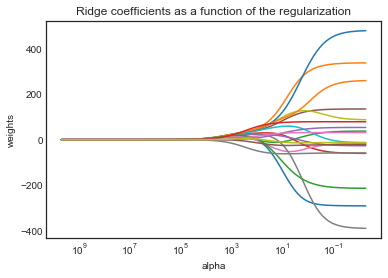

In [12]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)

C:\Users\galen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [17]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(x_train), y_train)
pred = ridge2.predict(scaler.transform(x_test))
mean_squared_error(y_test, pred)

C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


193147.46143016344

In [16]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.015146
Hits           0.016050
HmRun          0.013561
Runs           0.015681
RBI            0.016782
Walks          0.019662
Years          0.010390
CAtBat         0.016570
CHits          0.017627
CHmRun         0.015072
CRuns          0.018771
CRBI           0.016697
CWalks         0.016821
PutOuts        0.003228
Assists       -0.007600
Errors         0.013672
League_N       0.003519
Division_W     0.003339
NewLeague_N    0.003499
dtype: float64

In [21]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(x_train), y_train)
pred = ridge2.predict(scale(x_test))
mean_squared_error(y_test, pred)

C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


193253.09741651407

In [23]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(x_train), y_train)

C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


RidgeCV(alphas=array([5.00000e+09, 3.78232e+09, ..., 6.60971e-03, 5.00000e-03]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [24]:
ridgecv.alpha_

115.50648500415791

In [26]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(x_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(x_test)))

C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\galen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


97384.9295917259

In [27]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat           7.576771
Hits           22.596030
HmRun          18.971990
Runs           20.193945
RBI            21.063875
Walks          55.713281
Years          -4.687149
CAtBat         20.496892
CHits          29.230247
CHmRun         14.293124
CRuns          35.881788
CRBI           20.212172
CWalks         24.419768
PutOuts        16.128910
Assists       -44.102264
Errors         54.624503
League_N        5.771464
Division_W     -0.293713
NewLeague_N    11.137518
dtype: float64

In [30]:
grid = 10**np.linspace(10,-2,100)

ridge3 = gln.ElasticNet(alpha=0, lambda_path=grid)
ridge3.fit(X, y)

AttributeError: 'function' object has no attribute 'ElasticNet'